# Introduction to Spatial Audio

Welcome to the Spatial Audio workshop! Here we will explore the process of spatialising a raw, mono audio file with a process known as **Binaural Encoding**. This involves using special audio recordings known as **Head Related Transfer Functions** (or HRTFs), which are unique fingerprints for sound direction, to place our sounds in 3D space around us.

Let's begin with some module imports

In [1]:
# For audio
from audio_player import AudioPlayer  # To play our sound files
from SOFASonix import SOFAFile  # To load our spatial audio filters

# For 2d plotting
import matplotlib.pyplot as plt
import numpy as np

# Convenience
import time

# Plot graphs inline
%matplotlib inline 


## Loading the test audio file

We will now proceed with loading our test audio file. It is a mono audio file (1 channel) (courtesy of the Ableton live sample pack). Let's take a look at a graph of it.

Text(0, 0.5, 'Amplitude')

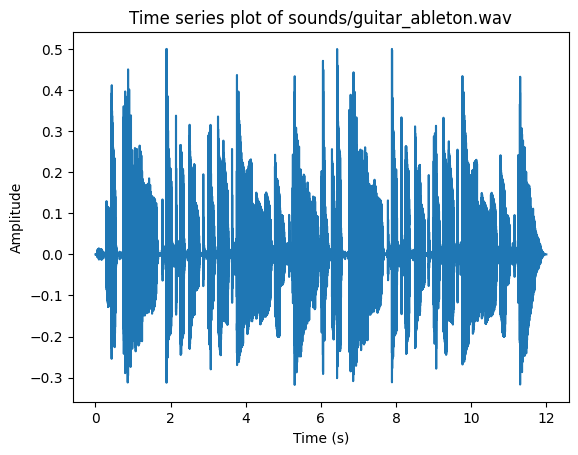

In [2]:
from audio_file_helpers import load_audio_file

filename = "sounds/guitar_ableton.wav"

# Read our soundfile into a numpy array (trim to 15 seconds)
audio_data, fs = load_audio_file(filename)
# Reduce our data in gain
audio_data *= 0.5

# Plot the time series of our soundfile
t = np.arange(0, audio_data.shape[0]) * 1/fs  # Convert samples units to seconds for x-axis
plt.figure()
plt.title(f"Time series plot of {filename}")
plt.plot(t, audio_data)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")


We can also listen to our sound file through both left and right speakers.

In [ ]:

# Create an audio player for our data
audio_player = AudioPlayer()

# Play our audio data
audio_player.play(audio_data, fs)

# Let's block the main thread until playback is done (we can force stop by commenting this code out)
while(audio_player.is_playing()):
    time.sleep(0.1)

audio_player.stop()

## Loading the HRTF Dataset

Now, we would like to 'spatialize' this sound file to be able to place it around us anywhere in space. For this we can load an HRTF dataset using the SOFASonix library. The HRTF dataset ```HRIR_CIRC_NF150.sofa``` is from the Koln database (https://zenodo.org/record/4297951) and has been measured using the Neumann KU100 artificial head (photo below)

<img style="max-width:150px; margin:auto; display:block" src="https://www.neumann.com/globalassets/digizuite/32398-en-ku_100product_detail_x1_desktop_ku-100-diagonal_neumann-dummy-head_m.png/ProductImageDesktop">

The dataset is of the type <a href="https://www.sofaconventions.org/mediawiki/index.php/SimpleFreeFieldHRIR">SimpleFreeFieldHRIR</a> as defined by the SOFA standard. This simply dictates the type and structure of data we are to expect within.


In [4]:
sofa_file = SOFAFile.load("HRIR_CIRC360_NF150.sofa", verbose=False)
assert(sofa_file.convention["name"] == "SimpleFreeFieldHRIR")

This dataset contains a total of 360 measurements of a loudspeaker with the Neumann KU100's in-ear microphones. Measurements were conducted with the loudspeaker: 
- at a distance of 1.5 meters from the KU100
- and at azimuthal angles ranging from 0-360

Hence this dataset will allow us to move sounds 360 degrees around us. Conveniently, it is arranged as such that the first dimension of the dataset (which is a 3 dimensional matrix) corresponds to the measurement angle in degrees.

## Inspecting the HRTF Dataset

Let's start with plotting the filters (or spatial fingerprints) for the left and right ears from the first measurement and 30th measurement (corresponding to the 0 degree angle, where the artificial head is directly looking at the speaker, and the 30 degree angle, with the speaker to the left of the listener).

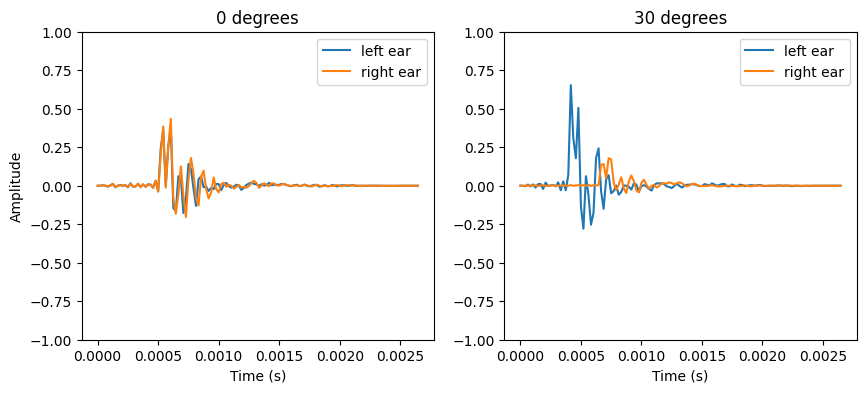

In [5]:
from plot_helper import plot_time_series

# Get the first measurement data (data_ir stands for data_impulse_response)
left_signal, right_signal = sofa_file.data_ir[0]
left_signal_30, right_signal_30 = sofa_file.data_ir[30]

# Create a time series array in seconds
fs_dataset = sofa_file.data_samplingrate[0]  # Dataset sample rate
t = np.arange(len(left_signal)) * 1/fs_dataset

# Plot the left and right signals
fig = plt.figure(figsize=(10,4))
angle_0 = fig.add_subplot(121)
angle_30 = fig.add_subplot(122)

# Plot the time series for the 0 degree signals
plot_time_series(angle_0, t, [left_signal, right_signal], ["left ear", "right ear"],
                     title = "0 degrees", xlabel = "Time (s)", ylabel = "Amplitude", ylim=[-1,1])

# Plot the time series for the 30 degree signals
plot_time_series(angle_30, t, [left_signal_30, right_signal_30], ["left ear", "right ear"],
                     title = "30 degrees", xlabel = "Time (s)", ylabel = "", ylim=[-1,1])


There are some interesting observations that can be made here:

1. The left and right ear signals for the 0 degree plot are perfectly in sync in time (their Interaural Time Difference, or ITD, is ~zero). They also have the same amount of energy, denoted by symmetrical peaks with the same amplitude(their Interaural Level Difference, or ILD, is ~zero). This is an indication that the listener is either forward facing, or backward facing to the sound source (remember the cone of confusion).
2. The left and right ear signals for the 30 degree plot show that the left ear receives the signal first, and the right ear receives it a few milliseconds later, at a much lower level (because of the sound diffracting around the head, and conducting through the head, before reaching the right ear, losing energy in the process). This coincides with the fact that this recording is of a loudspeaker 30 degress to the left of the artificial head. It's ITD and ILD are not-negligible, and contain the relevant spatial information

Let us view their spectral characteristics by taking a Fast Fourier Transform of the signals. This will show how the shape of the mannequin head affects the different frequencies within the signals.

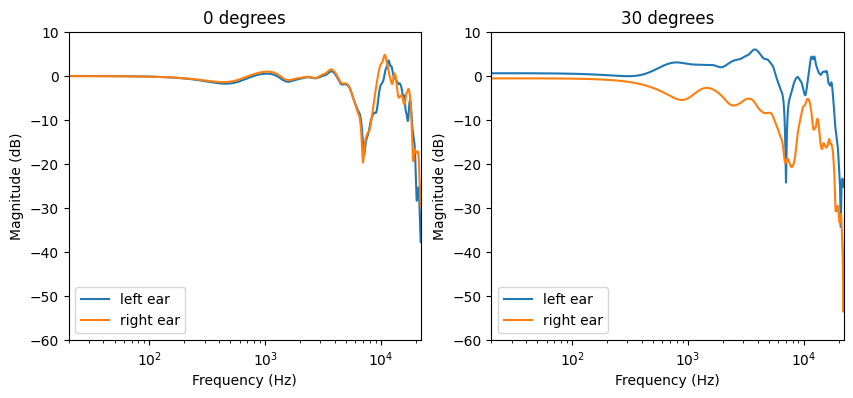

In [6]:
from plot_helper import plot_frequency_domain_magnitude

fft_size = 4096  # The size of the fourier transform, giving us a 4096 size array

# Compute the Fast Fourier Transform magnitudes of the 0 and 30 degree signals. Convert to decibels
left_signal_fft = 20*np.log10(np.abs(np.fft.fft(left_signal, n=fft_size)))
right_signal_fft =  20*np.log10(np.abs(np.fft.fft(right_signal, n=fft_size)))
left_signal_30_fft = 20*np.log10(np.abs(np.fft.fft(left_signal_30, n=fft_size)))
right_signal_30_fft =  20*np.log10(np.abs(np.fft.fft(right_signal_30, n=fft_size)))

# Compute the frequency vector
f = np.arange(0, fs, fs/fft_size)

# Plot the signals in the frequency domain
fig = plt.figure(figsize=(10, 4))
angle_0_fft = fig.add_subplot(121)
angle_30_fft = fig.add_subplot(122)

# Plot the magnitude of the 0 degree signals
plot_frequency_domain_magnitude(angle_0_fft, f, [left_signal_fft, right_signal_fft], ["left ear", "right ear"],
                                    title="0 degrees", xlabel="Frequency (Hz)", ylabel="Magnitude (dB)", 
                                    ylim=[-60,10], xlim=[20,fs//2])

# Plot the magnitude of the 30 degree signals
plot_frequency_domain_magnitude(angle_30_fft, f, [left_signal_30_fft, right_signal_30_fft], ["left ear", "right ear"],
                                    title="30 degrees", xlabel="Frequency (Hz)", ylabel="Magnitude (dB)", 
                                    ylim=[-60,10], xlim=[20,fs//2])


These magnitudes show us how the ILD varies across frequency in the 30 degree case. It is almost the same for the 0 degree case (slight dircrepancies are negligible and could be due to a variety of factors such as small recording assymetries, room imperfections, recording setup etc). We can finally inspect the metadata of the SOFA file to confirm that the loudspeaker was placed at 0 and 30 degrees relative to the listener, at a distance of 1.5m during recording.

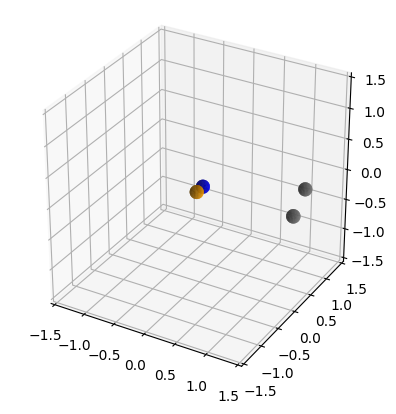

In [7]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from plot_helper import plot_sphere, spherical_to_cartesian_coordinates

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the limits
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-1.5, 1.5])

# Ensure equal aspect ratio
ax.set_box_aspect([1,1,1])  # aspect ratio is 1:1:1 in all directions

speaker_0_degrees = spherical_to_cartesian_coordinates(sofa_file.sourceposition[0, :])
speaker_30_degrees = spherical_to_cartesian_coordinates(sofa_file.sourceposition[30, :])

left_ear_pos = sofa_file.receiverposition[0, :, 0]
right_ear_pos = sofa_file.receiverposition[1, :, 0]

plot_sphere(ax, offset=speaker_0_degrees, diameter=.1, color="grey")
plot_sphere(ax, offset=speaker_30_degrees, diameter=.1, color="grey")

plot_sphere(ax, offset=left_ear_pos, diameter=.1, color="blue")
plot_sphere(ax, offset=right_ear_pos, diameter=.1, color="orange")



## Spatialising and listening to the test file

Finally, graphs are nice and all, but how about we actually use our spatial HRTF fingerprints to put our test sound in a specific location around us? Let's go!

In [53]:
# Let's place our test sound 30 degrees to the left
from audio_file_helpers import fade_in_out_audio_data

def binaural_encoder(test_signal, HRTF_pair):
    # Encode the signal for the left ear
    left_signal = np.convolve(test_signal, HRTF_pair[0], mode="same")
    right_signal = np.convolve(test_signal, HRTF_pair[1], mode="same")
    result = fade_in_out_audio_data(np.array([left_signal, right_signal]))
    return result

# Play sound 30 degrees to the left
spatial_30deg = binaural_encoder(audio_data, sofa_file.data_ir[30])
# Play sound -110 degrees to the right
spatial_250deg = binaural_encoder(audio_data, sofa_file.data_ir[250])


# Play our audio data
audio_player = AudioPlayer()
audio_player.play(spatial_30deg, fs)
# Let's block the main thread until playback is done (we can force stop by commenting this code out)
while(audio_player.is_playing()):
    time.sleep(0.1)
audio_player.stop()

audio_player.play(spatial_250deg, fs)
while(audio_player.is_playing()):
    time.sleep(0.1)
audio_player.stop()

Stopped playing
Stopped playing


## Creating a scene of sounds

As a final demonstration, we're going to create a jungle scene by combining a series of sounds (again, courtesy of the <a href="https://sound-effects.bbcrewind.co.uk/">BBC Sound Effects library</a>. We're going to create the following scene:

- Flowing river in the background (no spatialisation)
- A bird sound 30 degrees to our left
- Another bird sound 120 degrees to our right
- A forest cat mewoing 170 degrees to our left
- A monkey 10 degrees to our right
- A leopard snarling 50 degrees to our right

Let's go!

In [55]:
# Create a function for loading and trimming an audio file (with fade in-fade out)
from scipy import signal

trim_duration_in_seconds = 30

# Load all audio files, trimming their duration in seconds
background_river, fs = load_audio_file("./sounds/river_stereo.wav", duration=trim_duration_in_seconds)
bird, fs = load_audio_file("./sounds/bird.wav", duration=trim_duration_in_seconds)
bird2, fs = load_audio_file("./sounds/bird2.wav", duration=trim_duration_in_seconds)
cat, fs = load_audio_file("./sounds/cat.wav", duration=trim_duration_in_seconds)
leopard, fs = load_audio_file("./sounds/leopard.wav", duration=trim_duration_in_seconds)
monkey, fs = load_audio_file("./sounds/monkey.wav", duration=trim_duration_in_seconds)

bird_30deg_left = binaural_encoder(bird, sofa_file.data_ir[30])
bird2_120deg_right = binaural_encoder(bird2, sofa_file.data_ir[240])
cat_170deg_left = binaural_encoder(cat, sofa_file.data_ir[170])
leopard_50deg_right = binaural_encoder(leopard, sofa_file.data_ir[310])
monkey_10deg_right = binaural_encoder(monkey, sofa_file.data_ir[350])

# Let's lower the relative volume of our background_river
background_river = 0.5*background_river

# Now we must sum the signals together - (we reduce the overall gain)
final_signal = 0.5*np.sum((background_river, bird_30deg_left, bird2_120deg_right, cat_170deg_left, leopard_50deg_right, monkey_10deg_right), axis=0)

audio_player.play(final_signal, fs)
while(audio_player.is_playing()):
    time.sleep(0.1)
audio_player.stop()

Stopped playing
